# jPCA as a constrained LDS

_jPCA_ is a dimensionality reduction technique for neuroscience developed in Churchland _et al_. (2012) "Structure of neural population dynamics during reaching." _Nature_. The paper uses the jPCA dimensionality reduction technique to find oscillatory structure in neural recordings from monkeys during reaching. The following notebook demonstrates that jPCA can be thought of as learning a linear dynamical system (LDS) with a constraint on the $A$ matrix. A link to the original paper is [here](https://www.nature.com/articles/nature11129)

### 1. The generative model for jPCA is a simple Linear Dynamical System
$$\newcommand{\R}{\mathbb{R}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\Y}{\mathbf{Y}}
\newcommand{\x}{\mathbf{x}}
\newcommand{\X}{\mathbf{X}}
\newcommand{\Normal}{\mathcal{N}}
\newcommand{\Poiss}{\textnormal{Poiss}}
\DeclareMathOperator{\E}{\mathbb{E}}
\DeclareMathOperator{\tr}{\textnormal{tr}}
$$

We assume that we have measured some neural state $\x(t) \in \R^D$. Most often, PCA or another form of dimensionality reduction is applied as a preprocessing step, so that $D$ is less than the full dimensionality of the data, but this doesn't change any of the underlying ideas. The key assumption is that the neural state evolves according to simple linear dynamics:
\begin{equation}
    \dot{\x}(t) = M \x(t) \label{orig_lds}
\end{equation}

The original motivation for jPCA came from the assumption that the system should represent rotational transformations of the state vector, rather than expansions or contractions. This corresponds to constraining the dynamics matrix $M$ to be skew-symmetric ($M=-M^T$).

Standard jPCA estimates $M$ by solving a least-squares optimization problem. Since we have not directly observed $\dot\x(t)$, Churchland _et al_ approximate it using a first-difference: $\dot\x(t) \approx \x(t+\tau) - \x(t)$. Equivalently, in discrete time, $\dot\x_t \approx \x_{t+1} - \x_t$. Under this approximation, we can estimate $M$ by solving a least-squares problem where the objective is $\sum_{k=2}^K \| \x_{k} - \x_{k-1} - M\x_{k-1} \|_2^2$ subject to the constraint that $M$ is Skew-Symmetric.

The choice to use least-squares is equivalent to choosing a Gaussian noise model for the dynamics with identity covariance, and to assuming that we observe the state directly.

### 2. A probabilistic approach to jPCA

We can alternatively formulate jPCA by considering a linear dynamical system in discrete time:

\begin{equation*}
	\x_{k+1} = A \x_{k} + \epsilon
\end{equation*}

where epsilon is a (typically Gaussian) noise variable. If we constrain $A$ to be orthogonal, the system will represent rotations. Since SSM allows us to learn discrete-time linear dynamical systems from data, we can then use SSM to estimate the matrix $A$ using a modified EM algorithm where $A$ is constrained to be orthogonal during the M-Step. The probabilistic formulation allows us to include non-Gaussian measurement models (like Poisson models of spiking activity) as well as handle missing data.

One point of subtlety: constraining $A$ to be orthogonal is not enough to guarantee that the system will rotational. An orthogonal matrix can represent either a rotation (determinant 1) or a reflection (determinant -1). When learning the matrix $A$, we will take care to ensure that all eigenvalues are 1.


### 3. Computing the jPCA projections

Once we have estimated the matrix $A$ using SSM, we will need to project our data onto a 2-dimensional plane in order to visualize the rotations. Although our formulation differs slightly from the original formulation of jPCA (we have used a discrete-time system instead of continuous), the projection step works in the same way.

We compute the eigenvectors and eigenvalues of $A$. Each eigenvector and eigenvalue come in complex conjugate pairs. To find the plane of strongest rotation, we look at the plane spanned by the two eigenvectors associated with eigenvalues that have large imaginary components.

As a concrete example, we might have an $A$ matrix with the following eigenvalues: $0.92 + 0.15i, 0.92 - 0.15i, 0.98 + 0.04i, 0.98 - 0.04i$. The first two eigenvalues have the largest imaginary components, so we would look at the plane spanned by the first two eigenvectors ($V_1$ and $V_2$) in order to capture the strongest rotations. Though the eigenvectors are complex, following Churchland _et al_ we can find real vectors to project onto: $jPC_1 = V_1 + V_2$, $jPC_2 = i(V_1 - V_2)$. We have added a convenience function to ssm.util called `jPCA_project` which takes care of this process. Following the jPCA Matlab implementation, it also rotates the jPCs so that the starting points of the trajectories are spread along the horizontal axis.  
  




In [122]:
import copy
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.gridspec import GridSpec
from matplotlib.collections import LineCollection
from matplotlib import colors as mcolors
import matplotlib.patheffects as pe

import seaborn as sns

import ssm
from scipy.io import loadmat
from sklearn.decomposition import PCA


def load_churchland_data(path):
    """
    Load data from Churchland, Cunningham et al, Nature 2012
    Data available here: 
    https://churchland.zuckermaninstitute.columbia.edu/content/code
    
    Returns a 3D data array, C x T x N. T is the number of time bins,
    and N is the number of neurons (218), and C is the number of conditions.

    Note: Loading a .mat struct in Python is quite messy beause the formatting is messed up,
    which is why we need to do some funky indexing here.
    """
    struct = loadmat(path)
    conditions = struct["Data"][0]

    # For this dataset, times are the same for all conditions,
    # but they are formatted strangely -- each element of the times
    # vector is in a separate list.
    datas = None
    times = [t[0] for t in conditions[0][1]]
    
    for i, cond in enumerate(conditions):
        spikes = cond[0]
        if datas is None:
            datas = spikes
        else:
            datas = np.dstack((datas, spikes))
    
    datas = np.moveaxis(datas, 2, 0)
    return datas, times
    
    
def jpca_preprocess(datas,
                    times,
                    tstart=-50,
                    tend=150,
                    soft_normalize=5,
                    subtract_cc_mean=True,
                    pca=True,
                    num_pcs=6):
    """
    Preprocess data for jPCA. 
    
    Args
    ----
        datas: Array of size Conditions x Times x Neurons. As an example,
               this might be the output of load_churchland_data()
               
        times: List of times for the experiment. Typically, time zero corresponds
               to a stimulus onset. This list is used for extracting the set of
               data to be analyzed (see tstart and tend args).
               
        tstart: Integer. Starting time for analysis. For example, if times is [-10, 0 , 10]
                and tstart=0, then the data returned by this function will start
                at index 1.
                
        tend: Integer. Ending time for analysis.
        
        soft_normalize: Float or Int. Constant used during soft-normalization preprocessing step.
                        Adapted from original jPCA matlab code. Normalized firing rate is 
                        computed by dividing by the range of the unit across all conditions and times
                        plus the soft_normalize constant: Y_{cij} = (max(Y_{:i:}) - min(Y_{:i:}) + C)
                        where Y_{cij} is the cth condition, ith neuron, at the jth time bin.
                        C is the constant provided by soft_normalize. Set C negative to skip the 
                        soft-normalizing step.
                        
        subtract_cc_mean: Boolean. Whether or not to subtract the mean across conditions. Default True.
        
        pca: Boolean. True to perform PCA as a preprocessing step. Defaults to True.
        
        num_pcs: Int. When pca=True, controls the number of PCs to use. Defaults to 6.
        
    Returns
    -------
        datas: Array of size Conditions x Times x Units. Times will depend on the values
               passed for tstart and tend. Units will be equal to num_pcs if pca=True.
               Otherwise the number of units will remain unchanged.
    """
    
    num_conditions, num_time_bins, num_units = datas.shape

    if soft_normalize > 0:
        fr_range = np.max(datas, axis=(0,1)) - np.min(datas, axis=(0,1))
        datas /= (fr_range + soft_normalize)
        
    if subtract_cc_mean:
        cc_mean = np.mean(datas, axis=0)
        datas -= cc_mean

    # For consistency with the original jPCA matlab code,
    # we compute PCA using only the analyzed times.
    idx_start = times.index(tstart)
    idx_end = times.index(tend) + 1 # Add one so idx is inclusive
    datas = datas[:, idx_start:idx_end, :]
    num_time_bins = idx_end - idx_start
    
    if pca:
        # Reshape to perform PCA on all trials at once.
        datas = datas.reshape(num_time_bins * num_conditions, num_units)
        pca = PCA(num_pcs)
        datas = pca.fit_transform(datas)
        datas = datas.reshape(num_conditions, num_time_bins, num_pcs)
        
    return copy.deepcopy(datas)
    
    
def plot_trajectory(ax, x, y, 
                    color="black",
                    outline="black",
                    circle=True,
                    arrow=True):
    """
    Plot a single neural trajectory in a 2D plane.
    
    Args
    ----
        ax: Axis used for plotting.
        
        x: Values of variable on x-axis.
        
        y: Values of variable on y-axis.
        
        color: Fill color of line to be plotted. Defaults to "black".
        
        outline: Outline color of line. Defaults to "black".
        
        circle: True if the trajectory should have a circle at its starting state.
        
        arrow: True if the trajectory should have an arrow at its ending state.
        
    """
    ax.plot(x, y,
             color=color,
             path_effects=[pe.Stroke(linewidth=2, foreground=outline), pe.Normal()])
        
    if circle:
        circ = plt.Circle((x[0], y[0]),
                          radius=0.05, 
                          facecolor=color,
                          edgecolor="black")
        ax.add_artist(circ)

    if arrow:
        dx = x[-1] - x[-2]
        dy = y[-1] - y[-2]
        px, py = (x[-1], y[-1])
        ax.arrow(px, py , dx, dy, 
                  facecolor=color, 
                  edgecolor=outline,
                  length_includes_head=True,
                  head_width=0.05)
        
def plot_projections(data_list,
                     x_idx=0,
                     y_idx=1,
                     arrows=True,
                     circles=True,
                     sort_colors=True):
    """
    Plot trajectories found via jPCA or PCA. 
    
    Args
    ----
        data_list: List of trajectories, where each entry of data_list is an array of size T x D, 
                   where T is the number of time-steps and D is the dimension of the projection.

        x_idx: column of data which will be plotted on x axis. Default 0.

        y_idx: column of data which will be plotted on y axis. Default 0.

        arrows: True to add arrows to the trajectory plot.

        circles: True to add circles at the beginning of each trajectory.

        sort_colors: True to color trajectories based on the starting x coordinate. This mimics
                     the jPCA matlab toolbox.
    """
    fig = plt.figure(figsize=(5,5))
    colormap = plt.cm.RdBu
    colors = np.array([colormap(i) for i in np.linspace(0, 1, len(data_list))])
    
    if sort_colors:
        start_x = [data[0,x_idx] for data in datas]
        color_indices = np.argsort(start_x)

    ax = plt.gca()
    for i, data in enumerate(np.array(data_list)[color_indices]):
        plot_trajectory(ax,
                        data[:, x_idx],
                        data[:, y_idx],
                        color=colors[i],
                        circle=circles,
                        arrow=arrows)

### Data loading and preprocessing
The data we'll use in this demo is trial-averaged data from Churchland _et al_ 2012. It is available online at this [link](https://churchland.zuckermaninstitute.columbia.edu/content/code). The dataset consists of recordings from a monkey performing reaching tasks across a variety of conditions. In the task, the monkey is required to move his hand through a maze. Each different maze configuration corresponds to a different trial condition (108 conditions in all).

The data is processed using the following steps: 
1. **Normalization**. Each neurons firing rate is normalized to fall roughly in the same range.
2. **Mean Subtraction.** The cross-condition mean (mean across all conditions) is subtracted. This is because there is a large condition-independent change in the data, and subtracting it allows us to see rotations across conditions.
3. **PCA.** The data is projected on the first few (default 6) principle components.

These preprocessing steps are defined in more detail in Churchland _et al_ 2012, and in Mark Churchland's notes on jPCA, found at the above link. The following two lines below take care of loading and preprocessing the data:
```python
datas, times = load_churchland_data(DATA_PATH)
datas = jpca_preprocess(datas, times, pca=True, num_pcs=N)
```

The first line loads the Matlab struct containing the data. The second line does the preprocessing steps mentioned above. The output of the `jpca_preprocess` function is a 3D array of size $C \times T \times D$ where $C$ is the number of conditions (108 in this case), $T$ is the number of time-steps for each conditions (21 by default), and $D$ is the dimensionality of the reduced dimension data (default 6).

In [127]:
N = 6
D = 6

DATA_PATH = "/Users/Bantin/Documents/Linderman-Shenoy/jPCA_ForDistribution/exampleData.mat"
datas, times = load_churchland_data(DATA_PATH)
datas = jpca_preprocess(datas, times, pca=True, num_pcs=N)

### Fitting a rotational LDS

We will find low-dimensional structure in this dataset by fitting a linear dynamical system with rotational dynamics. 
First, we reformat our data as a list of realizations, where each entry in the list is $T \times D$. In order to replicate the results of traditional jPCA, we have set both the latent dimension ($D$) and the observed dimension ($N$) to be 6.

The following line create an LDS with rotational dynamics:
```python
lds = ssm.LDS(N, D, dynamics="rotational", emissions="gaussian_id", method="laplace-em")
```
Setting `dynamics="rotational"` will ensure that the $A$ matrix we recover is orthogonal. In order to match the original jPCA formulation, we set the emissions model to simply be equal to the state plus i.i.d Gaussian noise (`emissions="gaussian_id"`). The rotational dynamics model can currently only be fit using the Laplace-EM algorithm -- with Gaussian dynamics and emissions, the Laplace-EM algorithm is equivalent to the standard EM algorithm.

**Note 1:** Currently, the "rotational" dynamics class assumes that the dynamics noise is identity Gaussian. We are working on generalizing this to support other noise models for the dynamics.

**Note 2:** The formulation of jPCA as a rotational LDS works with any emissions model. However, with a non-identity measurement matrix (e.g if we set `emissions="gaussian"`) the projection step needs to account for this linear transformation. This is not yet built into the `jpca_project` function.

Initializing with an ARHMM using 25 steps of EM.


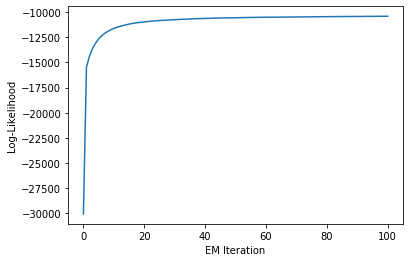

In [128]:
data_list = [Y for Y in datas]
lds = ssm.LDS(N, D, dynamics="rotational", emissions="gaussian_id", method="laplace-em")
elbos, posterior = lds.fit(data_list, num_iters=100)
plt.plot(elbos)
plt.xlabel("EM Iteration")
plt.ylabel("Log-Likelihood")
plt.show()

### Visualizing Rotations

Once we have learned our LDS, we are interested in two quantities: the posterior distribution over the latent states (this is equivalent to smoothing the data with a Kalman smoother), and the orthogonal dynamics matrix $A$.

We use the `jPCA_project` function (part of `ssm.preprocessing`) to project the smoothed latent states on the first jPC plane. The `jPCA_project` function takes 3 arguments:

1. **A list of state trajectories**. This can be the smoothed latent states, as in the case below. When the data itself has the same dimension as the latent state, we could also project the raw data itself. For instance, we could replace `posterior.mean_continuous_states` with `data_list` and get nearly identical results.

2. **Dynamics Matrix**. This is the dynamics matrix learned in the above cell.

3. **Number of components**. This is how many components to compute and project onto. It must be an even number, so that each projection corresponds to a plane. For example, to get the first two jPCA planes, we would set `num_components=4`.

`jPCA_project` returns a list of projected data. Each element of the list is $T$ x Num_Components, where $T$ is the amount of time in each trial.

We then use the `plot_projections` function to plot the neural state trajectories in the first jPCA plane. 
We pass in the projection onto the first few principle components, and then specify which index to plot on the horizontal and vertical axes, respectively. For example, to make plots for both the first and second jPCA planes, the code would look like this:

```
projected_datas = ssm.preprocessing.jPCA_project(
    posterior.mean_continuous_states,
    lds.dynamics.A,
    num_components=4
    )

plot_projections(projected_datas, x_idx=0, y_idx=1)
plot_projections(projected_datas, x_idx=2, y_idx=3)
```
However, since we preprocessed using only the first 6 PCs, there is not much structure in the second plane. If we want to look at more than one jPCA plane, we should preprocess using more PCs (e.g 12).

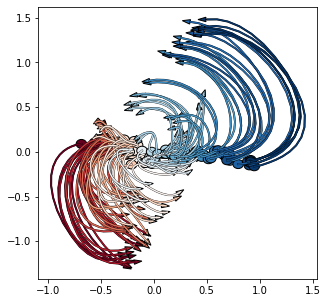

In [131]:
projected_datas = ssm.preprocessing.jPCA_project(
    posterior.mean_continuous_states,
    lds.dynamics.A,
    num_components=2
    )

plot_projections(projected_datas, x_idx=0, y_idx=1)